In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [ ]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, 
                           n_redundant=0, weights=[0.9, 0.1], random_state=42)

array([[ 3.86239664, -0.53555708, -0.01563761, ..., -0.33032079,
         3.25494185,  1.42375408],
       [-2.75566887,  0.81133032, -3.80487368, ..., -2.12421181,
        -1.9777969 ,  0.55165227],
       [ 1.37952235,  0.86515655,  2.43884712, ...,  1.18589537,
         0.81238553,  1.29054823],
       ...,
       [ 1.36226452,  0.08528407,  1.03930722, ..., -0.68740592,
         2.42238562,  1.73966525],
       [-1.19160029,  0.37709022,  1.58535027, ..., -2.02342646,
        -0.02961941, -1.07821817],
       [ 1.46458697,  0.39844805,  2.07032359, ...,  0.59166715,
         0.43877996,  0.30288328]], shape=(1000, 10))

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [ ]:
ratio= float(np.sum(y_train== 0) / np.sum(y_train== 1))
print(ratio)

9.126582278481013


In [ ]:
model = xgb.XGBClassifier(
    n_estimators= 100,
    max_depth= 4,
    learning_rate= 0.1,
    scale_pos_weight= ratio,
    objective= 'binary:logistic',
    eval_metric= 'logloss'
)

model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [ ]:
y_pred= model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [ ]:
print("--- Credit Risk Model Report ---")
print(classification_report(y_test, y_pred))
print(f'ROC-AUC Curve: {roc_auc_score(y_test, y_pred):.4f}')

--- Credit Risk Model Report ---
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       176
           1       0.78      0.88      0.82        24

    accuracy                           0.95       200
   macro avg       0.88      0.92      0.90       200
weighted avg       0.96      0.95      0.96       200

ROC-AUC Curve: 0.9205


d:\AI-Finance\AI-Finance_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generating Global Feature Importance...


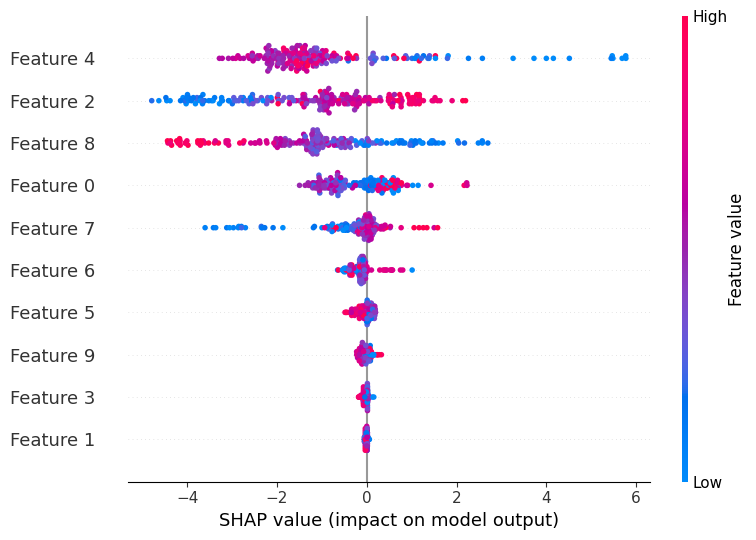

Explaining a single prediction...


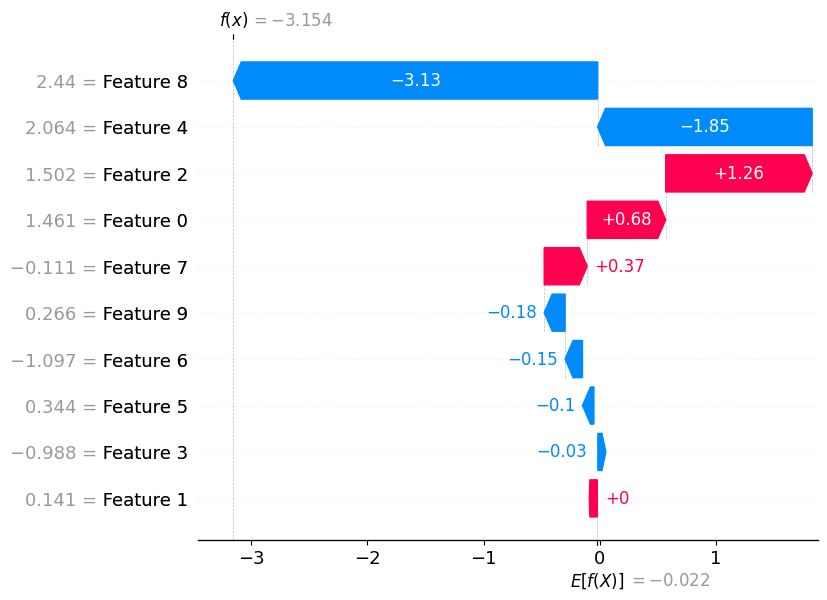

In [ ]:
import shap

explainer= shap.Explainer(model)
shap_values= explainer(X_test)

print("Generating Global Feature Importance...")
shap.summary_plot(shap_values, X_test)

print("Explaining a single prediction...")
shap.waterfall_plot(shap_values[0])

In [ ]:
# Assume a False Negative (Defaulter approved) costs 5x more 
# than a False Positive (Good customer rejected).

thresholds = np.linspace(0, 1, 100)
costs = []

for t in thresholds:
    y_pred_t = (y_proba > t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    
    # Financial Cost Function
    total_cost = (fp * 1) + (fn * 5) 
    costs.append(total_cost)

best_threshold = thresholds[np.argmin(costs)]
print(f"The Mathematically Optimal Threshold for the Bank is: {best_threshold:.2f}")

The Mathematically Optimal Threshold for the Bank is: 0.51


## Week 7-8

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance

ticker= 'RELIANCE.NS'
data = yf.download(ticker, start="2018-01-01", end="2024-01-01")
data.head()

C:\Users\sober\AppData\Local\Temp\ipykernel_9872\2968657356.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2018-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Date,,,,,
2018-01-01,401.864777,407.585177,400.870881,407.585177,9453202
2018-01-02,402.483185,406.193737,400.384963,403.300393,9499419
2018-01-03,404.095520,409.042914,403.322483,408.601166,13507800
2018-01-04,406.525055,407.187662,404.493091,405.575331,9008932
2018-01-05,407.828156,409.440487,406.502971,407.187664,7441284


In [ ]:
data['MA50']= data['Close'].rolling(window=50).mean()

data['Returns']= data['Close'].pct_change()
data['Volatility']= data['Returns'].rolling(21).std()

delta= data['Close'].diff()
gain= (delta.where(delta > 0, 0)).rolling(14).mean()
loss= (-delta.where(delta < 0, 0)).rolling(14).mean()
rs= gain / loss
data['RSI'] = 100 - (100 / 1 - rs)

data['Target'] = np.where(data['Returns'].shift(-1) > 0, 1, 0)

data.dropna(inplace= True)

In [ ]:
# data.head(25)

In [ ]:
split= int(len(data) * 0.8)
features= ['MA50', 'Volatility', 'RSI']
X_train, X_test = data[features].iloc[:split], data[features].iloc[split:]
y_train, y_test = data['Target'].iloc[:split], data['Target'].iloc[split:]

In [ ]:
model = xgb.XGBClassifier(n_estimators= 100, max_depth= 3, learning_rate= 0.05)
model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

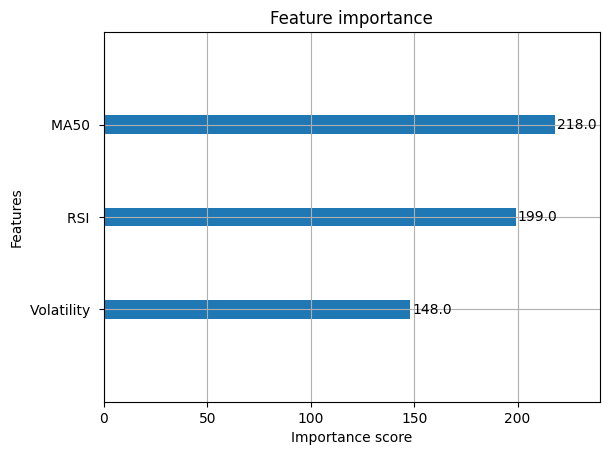

In [ ]:
plt.Figure(figsize= (10,6))
plot_importance(model)
plt.show()

In [ ]:
ticker= 'RELIANCE.NS'
df= yf.download(ticker, start="2019-01-01", end="2024-01-01")

df['MA50'] = df['Close'].rolling(50).mean()
df['Returns']= df['Close'].pct_change()
df['Volatility'] = df['Returns'].rolling(21).std()
delta= df['Close'].diff()
gain= (delta.where(delta > 0, 0)).rolling(14).mean()
loss= (-delta.where(delta < 0, 0)).rolling(14).mean()
df['RSI'] = 100 - (100 / 1 + (gain / loss))
df['Target'] = np.where(df['Returns'].shift(-1) > 0, 1, 0)
df.dropna(inplace= True)

C:\Users\sober\AppData\Local\Temp\ipykernel_9872\472761729.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df= yf.download(ticker, start="2019-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


In [ ]:
train_size= 252
test_step= 21
predictions= []

for i in range(train_size, len(df) - test_step, test_step):
    train_data= df.iloc[i - train_size: i]
    test_data= df.iloc[i : i + test_step]

    X_train = train_data[['MA50', 'Volatility', 'RSI']]
    y_train = train_data['Target']
    X_test = test_data[['MA50', 'Volatility', 'RSI']]

    model = xgb.XGBClassifier(n_estimators= 100, max_depth= 4, learning_rate= 0.5, verbosity= 0)
    model.fit(X_train, y_train)

    preds= model.predict(X_test)
    predictions.extend(preds)

In [ ]:
results_df= df.iloc[train_size : train_size + len(predictions)].copy()
results_df['AI Signal'] = predictions

cost_per_trade= 0.001

results_df['AI Returns'] = results_df['AI Signal'] * results_df['Returns']

results_df['Trade Executed']= results_df['AI Signal'].diff().abs().fillna(0)
results_df['Strategic Returns'] = results_df['AI Returns'] - (results_df['Trade Executed'] * cost_per_trade)

results_df['Cum Market'] = (1 + results_df['Returns']).cumprod()
results_df['AI Cum Returns'] = (1 + results_df['Strategic Returns']).cumprod()

results_df.sample()

Price,Close,High,Low,Open,Volume,MA50,Returns,Volatility,RSI,Target,AI Signal,AI Returns,Trade Executed,Strategic Returns,Cum Market,AI Cum Returns
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,
2021-09-28,1159.393311,1167.060236,1143.354064,1153.000335,18035258,1018.261865,0.009349,0.01407,-1.913463,0,0,0.0,0.0,0.0,2.747163,0.977361


In [ ]:
import plotly.graph_objects as go

fig= go.Figure()
fig.add_trace(go.Scatter(x=results_df.index, y=results_df['Cum Market'], name="Buy & Hold (Reliance)"))
fig.add_trace(go.Scatter(x=results_df.index, y=results_df['AI Cum Returns'], name="AI Strategy (Net of Costs)"))
fig.update_layout(title="Walk-Forward Performance: AI vs. Benchmark", 
                  xaxis_title="Date", yaxis_title="Growth of ₹1", template="plotly_dark")
fig.show()

## Project 3C

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

tickers = ["RELIANCE.NS", "TCS.NS", "HDFCBANK.NS", "INFY.NS", "ICICIBANK.NS"]
data = yf.download(tickers, period="2y")['Close']

ai_signals = {
    "RELIANCE.NS": 0.85,
    "TCS.NS": 0.45,
    "HDFCBANK.NS": 0.65,
    "INFY.NS": 0.50,
    "ICICIBANK.NS": 0.90
}

C:\Users\sober\AppData\Local\Temp\ipykernel_9872\3216604778.py:6: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  5 of 5 completed


In [ ]:
mu_historical= expected_returns.mean_historical_return(data)

mu_ai_historical= mu_historical * (pd.Series(ai_signals) / 0.5)

S = risk_models.sample_cov(data)

ef = EfficientFrontier(mu_ai_historical, S)

ef.add_constraint(lambda w: w <= 0.30)

weights= ef.max_sharpe()
cleaned_weights= ef.clean_weights()

In [ ]:
total_portfolio_value = 100000
latest_prices= get_latest_prices(data)
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value)
allocation, leftover= da.greedy_portfolio()

for ticker, shares in allocation.items():
    investment= shares * latest_prices[ticker]
    print(f"{ticker}: Buy {shares} shares (Value: ₹{investment:,.2f})")

print(f"\nRemaining Cash: ₹{leftover:.2f}")

ICICIBANK.NS: Buy 21 shares (Value: ₹30,135.00)
HDFCBANK.NS: Buy 32 shares (Value: ₹30,294.40)
RELIANCE.NS: Buy 18 shares (Value: ₹26,470.80)
INFY.NS: Buy 8 shares (Value: ₹12,906.40)

Remaining Cash: ₹193.40


In [ ]:
perf_ai = ef.portfolio_performance(verbose= True)

n= len(tickers)
equal_weights= np.array([1/n] * n)
ret_equal= np.dot(equal_weights, mu_historical)
vol_equal= np.sqrt(np.dot(equal_weights.T, np.dot(S, equal_weights)))
sharpe_equal= (ret_equal - 0.02) / vol_equal

print(f"\n--- Comparison Summary ---")
print(f"AI-Optimized Sharpe: {perf_ai[2]:.2f}")
print(f"Equal-Weighted Sharpe: {sharpe_equal:.2f}")

Expected annual return: 19.2%
Annual volatility: 14.3%
Sharpe Ratio: 1.35

--- Comparison Summary ---
AI-Optimized Sharpe: 1.35
Equal-Weighted Sharpe: 0.43


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

ticker = "^NSEI" # NIFTY 50
df = yf.download(ticker, period="3y")

if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

C:\Users\sober\AppData\Local\Temp\ipykernel_9872\2547732057.py:5: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Feature 1: Returns (Momentum)
df['Returns'] = df['Close'].pct_change()
# Feature 2: Rolling Volatility (21-day)
df['Volatility'] = df['Returns'].rolling(window=21).std()
# Feature 3: RSI (Momentum/Exhaustion)
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
df['RSI'] = 100 - (100 / (1 + (gain / loss)))

df.dropna(inplace=True)

In [ ]:
features= ['Returns', 'Volatility', 'RSI']
scaler=  StandardScaler()
scaled_data = scaler.fit_transform(df[features])

In [ ]:
model = KMeans(n_clusters= 3, n_init= 10, random_state= 42)
df['Regime'] = model.fit_predict(scaled_data)

analysis = df.groupby('Regime')[['Returns', 'Volatility']].mean()
print("--- Cluster Analysis ---")
print(analysis)

--- Cluster Analysis ---
Price    Returns  Volatility
Regime                      
0       0.002530    0.005887
1      -0.002777    0.006904
2       0.007222    0.012870


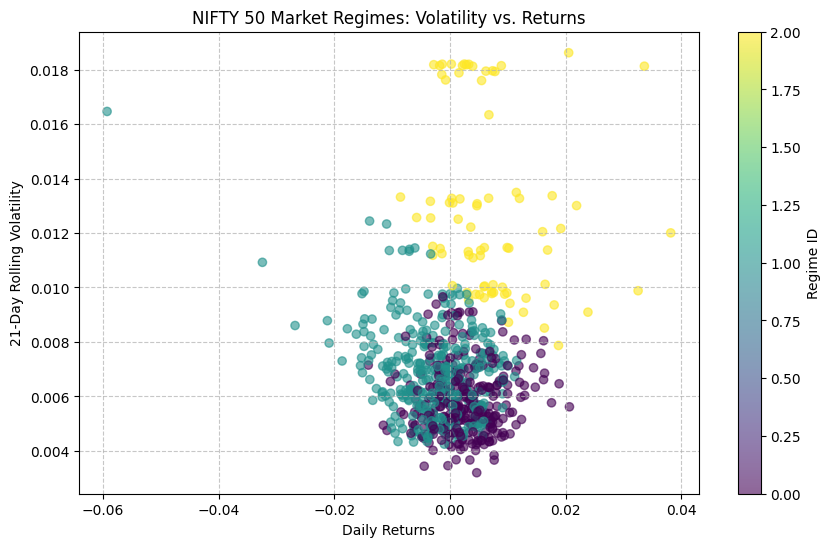

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['Returns'], df['Volatility'], c=df['Regime'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Regime ID')
plt.title('NIFTY 50 Market Regimes: Volatility vs. Returns')
plt.xlabel('Daily Returns')
plt.ylabel('21-Day Rolling Volatility')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
from transformers import pipeline

print("Loading FinBERT Model... (Approx 400MB)")
sentiment_pipe = pipeline('sentiment-analysis', model= 'ProsusAI/finbert')

Loading FinBERT Model... (Approx 400MB)


Device set to use cpu


In [ ]:
headlines = [
    "Reliance Industries Q3 profits jump 15% on strong O2C performance",
    "SEBI issues notice to major Indian corporations over disclosure norms",
    "Foreign Institutional Investors (FII) pour $2 billion into NIFTY 50",
    "Indian Rupee hits record low against USD amid global inflation concerns",
    "Reliance Jio adds 4 million new subscribers, dominating the telecom space"
]

results= sentiment_pipe(headlines)

df = pd.DataFrame(results)
df['Headlines']= headlines

In [ ]:
def calculate_score(row):
    if row['label'] == 'positive':
        return row['score']
    if row['label'] == 'negative':
        return -row['score']
    else:
        return 0
    
df['Sentiment_Value'] = df.apply(calculate_score, axis= 1)
daily_sentiment = df['Sentiment_score'].mean()

In [ ]:
def make_trade_decision(price_signal, sentiment_score):
    print(f"\n--- Decision Engine Analysis ---")
    print(f"Price Signal: {price_signal} | Sentiment Score: {daily_sentiment:.2f}")
    
    if price_signal == 'Up' and sentiment_score > 0.2:
        return "🔥 STRONG BUY: Quant and Qual signals aligned."
    elif price_signal == 'Up' and sentiment_score < -0.2:
        return "⚠️ WAIT/NEUTRAL: Price is rising but news is bearish (Potential Trap)."
    elif price_signal == 'Down' and sentiment_score < -0.2:
        return "📉 STRONG SELL: Sentiment confirms price breakdown."
    else:
        return "⚖️ HOLD: Mixed signals or low conviction."


decision = make_trade_decision(price_signal='Up', sentiment_score=daily_sentiment)
print(f"Final Action: {decision}")

print("\n--- Detailed Sentiment Report ---")
print(df[['Headlines', 'label', 'Sentiment_Value']])


--- Decision Engine Analysis ---
Price Signal: Up | Sentiment Score: 0.06
Final Action: ⚖️ HOLD: Mixed signals or low conviction.

--- Detailed Sentiment Report ---
                                           Headlines     label  \
0  Reliance Industries Q3 profits jump 15% on str...  positive   
1  SEBI issues notice to major Indian corporation...  negative   
2  Foreign Institutional Investors (FII) pour $2 ...   neutral   
3  Indian Rupee hits record low against USD amid ...  negative   
4  Reliance Jio adds 4 million new subscribers, d...  positive   

   Sentiment_Value  
0         0.945516  
1        -0.561593  
2         0.000000  
3        -0.922615  
4         0.849213  
